In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='7'

# Optimizing trough GMRES

This example demostrates how it is possible to take advantage of the [`implicit function theorem`](https://jax.readthedocs.io/en/latest/notebooks/Custom_derivative_rules_for_Python_code.html#Implicit-function-differentiation-of-iterative-implementations) to differentiate trough a fixed point algorithm with $O(1)$ memory requirement, Here, the iterative solver is given by GMRES, which is used to solve the Helmholtz equation.

A great discussion about taking derivatives of a generic fixed-point algorithm is given in the [DEQ paper](https://arxiv.org/pdf/2006.08656.pdf)

## Helmholtz equation

We'll assume to transmit waves from a set of $n$ transducers, which act as monopole sources: that means that we can define an apodization vector 

$$
\mathbf a = (a_0, \dots, a_n), \qquad a_i \in \mathbb{C}, \; \|a_i\| < 1
$$

such that $\rho(\mathbf a)$ is the transmit wavefield. The unit norm constraint is needed to enforce the fact that each transducer has an upper limit on the maximum power it can transmit.

We could use several methods to represent this vector and its constraint. Here, we use

$$
a_j(\rho_j, \theta_j) = \frac{e^{i\theta_j}}{1 + \rho_j^2}.
$$

## Focusing

Often, we want to find the apodization vector which returns a field having certain properties. For example, in a neurostimulation session we may want to maximize the acoustic power delivered to a certain spot, while keeping the acoustic field below an arbitrary treshold in another region.

Let's call $\mathbf p\in\mathbb{R}^2$ the point where we want to maximize the wavefield. For a field $\phi(\mathbf x,\mathbf a)$ generated by the apodization $\mathbf a$, the optimal apodization is then given by

$$
\hat {\mathbf a} = \operatorname*{arg\,max}_{\mathbf a} \|\phi(\mathbf p, \mathbf a) \|
$$

We start by setting up the simulation:

In [3]:
from jax import numpy as jnp
import numpy as np
from functools import partial
from jax import random
import jax

key = random.PRNGKey(42)

In [4]:
# Defining geometry
from jwave.geometry import Domain, Medium
from jwave import FourierSeries

N = (320, 512)         # Grid size
dx = (1., 1.)          # Spatial resolution
omega = 1.              # Wavefield omega = 2*pi*f
target = [160,360]     # Target location

# Making geometry
domain = Domain(N, dx)

# Constructing medium physical properties
sound_speed = jnp.ones(N)
sound_speed = sound_speed.at[20:80,50:80].set(2.)
sound_speed = sound_speed.at[80:140,50:100].set(1.5)
sound_speed = sound_speed.at[140:220,45:130].set(1.3)
sound_speed = jnp.expand_dims(sound_speed.at[220:300,70:100].set(1.8), -1)
sound_speed = FourierSeries(sound_speed, domain)

medium = Medium(
    domain=domain,
    sound_speed=sound_speed,
    pml_size=15
)

# Build the vector that holds the parameters of the apodization an the
# functions required to transform it into a source wavefield
transmit_phase = jnp.concatenate([jnp.ones((32,)), jnp.ones((32,))])
position = list(range(32, 32+(8*32), 8))

def phase_to_apod(phases):
    dim = len(phases)//2
    return jnp.exp(1j*phases[dim:])/(1+(phases[:dim])**2)

def phases_to_field(phases, domain):
    phases = phase_to_apod(phases)
    src_field = jnp.zeros(domain.N).astype(jnp.complex64)
    src_field = src_field.at[position, 25].set(phases)
    return FourierSeries(jnp.expand_dims(src_field, -1), domain)

linear_phase = phases_to_field(transmit_phase, domain)

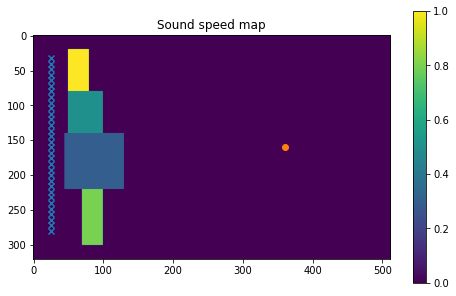

In [5]:
from matplotlib import pyplot as plt
from jwave.utils import plot_complex_field, show_positive_field

plt.figure(figsize=(8,5))

plt.imshow(medium.sound_speed.on_grid)
plt.title("Sound speed map")
plt.scatter([25]*len(position),position, marker='x', label="Transducers")
plt.scatter(target[1], target[0], label="Target")
plt.colorbar()

dict_keys(['pml_on_grid', 'fft_u'])


(<Figure size 1080x576 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Real wavefield'}>,
        <AxesSubplot:title={'center':'Wavefield magnitude'}>], dtype=object))

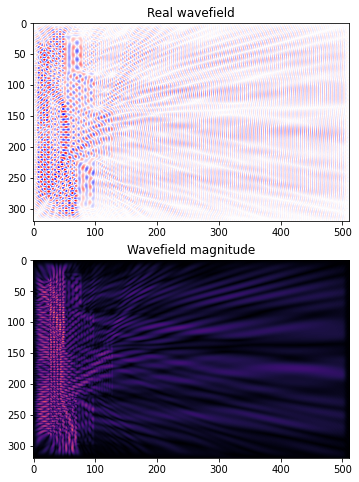

In [6]:
from jwave.acoustics.time_harmonic import helmholtz_solver
from jwave.acoustics.operators import helmholtz
from jax import jit

op_params = helmholtz(linear_phase, medium, omega=1.0)._op_params
print(op_params.keys())

@jit
def fixed_medium_solver(src_field, guess=None, tol=1e-2):
    return helmholtz_solver(medium, omega, src_field, guess=guess, tol=tol, params = op_params)

field = fixed_medium_solver(linear_phase)
plot_complex_field(field)

We can now define our loss function $L(\mathbf a)$ and perform gradient descent, to reach a local minima.

Note that this is possible because the GMRES implementation, which computes the solution of the Helmholtz problem, is differentiable. 

In [7]:
from jax import value_and_grad, vmap

In [8]:
def loss(field):
    field = field.on_grid
    return -jnp.sum(jnp.abs(field[target[0],target[1]]))

def get_field(transmit_phase, tol, guess):
    transmit_field = phases_to_field(transmit_phase, domain)
    return fixed_medium_solver(transmit_field, guess, tol)

def full_loss(transmit_phase, tol, guess):
    field = get_field(transmit_phase, tol, guess)
    return loss(field), field

loss_with_grad = value_and_grad(full_loss, has_aux=True)

In [9]:
from jax.example_libraries import optimizers
from jax import jit
from tqdm import tqdm

losshistory = []

init_fun, update_fun, get_params = optimizers.adam(.1, b1=0.9, b2=0.9)
opt_state = init_fun(transmit_phase)

@partial(jit, static_argnums=(1,))
def update(opt_state, tol, guess):
    loss_and_field, gradient = loss_with_grad(get_params(opt_state), tol, guess)
    lossval = loss_and_field[0]
    field = loss_and_field[1]
    return lossval, field, update_fun(k, gradient, opt_state)

pbar = tqdm(range(100))
tol = 1e-2
guess = None
for k in pbar:
    lossval, guess, opt_state = update(opt_state, tol, guess)
        
    # For logging
    pbar.set_description("Ampl: {:01.4f}".format(-lossval))
    losshistory.append(lossval)
    
transmit_phase = get_params(opt_state)

Ampl: 0.0332:   1%|▋                                                                      | 1/100 [00:29<49:14, 29.84s/it]


KeyboardInterrupt: 

Following is the wavefield for the optimized apodization

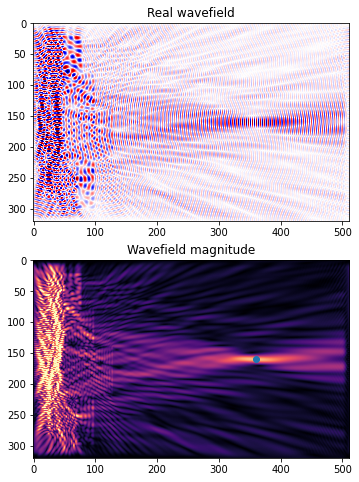

In [12]:
transmit_phase = get_params(opt_state)
field = get_field(transmit_phase, 1e-3, guess)
_ = plot_complex_field(field, max_intensity=0.3)
plt.scatter(target[1], target[0])

Lastly, we can visualize the learned apodization

Text(0.5, 1.0, 'Apodization')

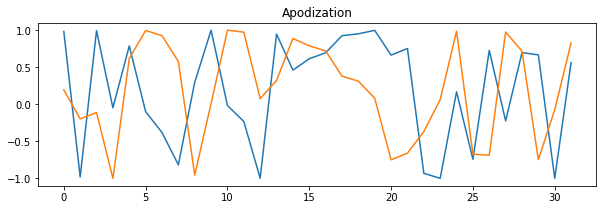

In [13]:
plt.figure(figsize=(10,3))
plt.plot(jnp.real(phase_to_apod(transmit_phase)))
plt.plot(jnp.imag(phase_to_apod(transmit_phase)))
#plt.plot(jnp.abs(phase_to_apod(transmit_phase)), "r.")
plt.title("Apodization")

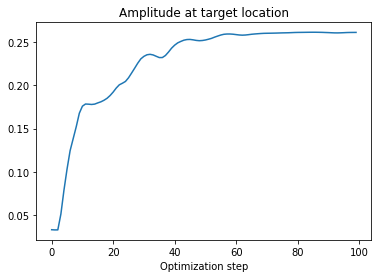

In [14]:
plt.plot(-jnp.array(losshistory))
plt.title("Amplitude at target location")
plt.xlabel("Optimization step")
plt.show()

## Speed of sound gradients

Gradients can be evaluated with respect to every parameter of the simulation. In this example, we will keep the source term fixed and vary the density of an acoustic lens to focus on a target.

In [5]:
from jwave.signal_processing import smooth
from jax import random

key = random.PRNGKey(12)

In [6]:
target = [60,360]     # Target location

# Constructing medium physical properties
def get_sos(segments, start_point=30, height=4, width=30):
    sos = jnp.ones(N)
    for k in range(len(segments)):
        sos = sos.at[start_point+k*height:start_point+(k+1)*height, 50:50+width].add(
            jax.nn.sigmoid(segments[k])
        )
    return FourierSeries(jnp.expand_dims(sos, -1), domain)

In [7]:
key, _ = random.split(key)
sos_control_points = random.normal(key, shape=(65,))
sos = get_sos(sos_control_points)

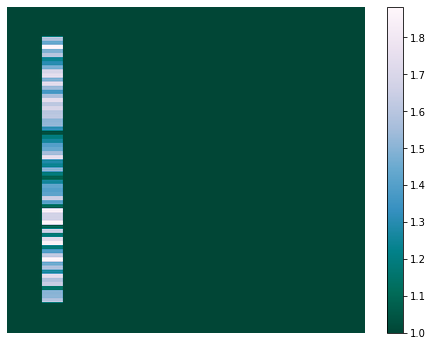

In [8]:
show_positive_field(sos)

In [43]:
from jwave.acoustics.operators import helmholtz

medium = Medium(domain, sound_speed=get_sos(sos_control_points))
op_params = helmholtz(linear_phase, medium, omega=1.0)._op_params
print(op_params.keys())

dict_keys(['pml_on_grid', 'fft_params'])


In [44]:
from jax import value_and_grad
from jwave.acoustics.time_harmonic import helmholtz_solver

def loss(field):
    field = field.on_grid
    return -jnp.sum(jnp.abs(field[target[0],target[1]]))

def get_field(params, tol, field):
    medium = Medium(domain, sound_speed=get_sos(params))
    return helmholtz_solver(medium, 1.0, linear_phase, guess=field, tol=tol, checkpoint=True, params=op_params)

def full_loss(params, tol, field):
    field = get_field(params, tol, field)
    return loss(field), field

loss_with_grad = value_and_grad(full_loss, has_aux=True)

In [46]:
from jax.example_libraries import optimizers
from jax import jit
from tqdm import tqdm

losshistory = []

key, _ = random.split(key)
sos_vector = random.normal(key, shape=(65,))

init_fun, update_fun, get_params = optimizers.adam(.1, b1=0.9, b2=0.9)
opt_state = init_fun(sos_control_points)

@jit
def update(opt_state, tol, field):
    loss_and_field, gradient = loss_with_grad(get_params(opt_state), tol, field)
    lossval = loss_and_field[0]
    field = loss_and_field[1]
    return lossval, field, update_fun(k, gradient, opt_state)

pbar = tqdm(range(100))
tol = 1e-2
field = -linear_phase
for k in pbar:
    lossval, field, opt_state = update(opt_state, tol, field)
        
    # For logging
    pbar.set_description("Tol: {} Ampl: {:01.4f}".format(tol, -lossval))
    losshistory.append(lossval)
    
transmit_phase = get_params(opt_state)

Tol: 0.01 Ampl: 0.1897: 100%|███████████████████████████████████████████████████████████| 100/100 [04:03<00:00,  2.43s/it]


Text(0.5, 1.0, 'Amplitude at target location')

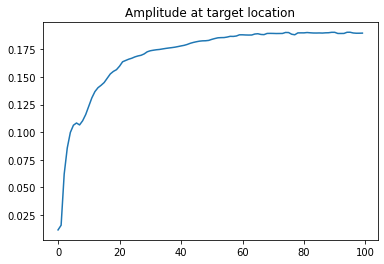

In [47]:
plt.plot(-jnp.array(losshistory))#
plt.title("Amplitude at target location")

In [48]:
opt_sos_vector = get_params(opt_state)

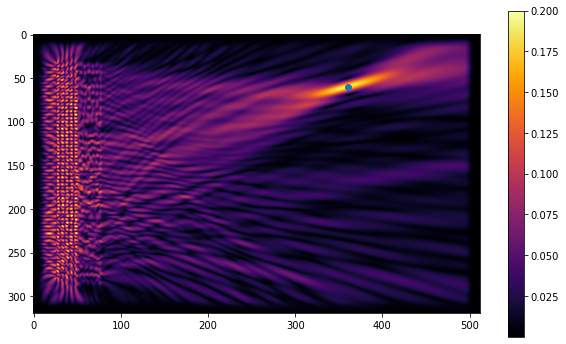

In [50]:
plt.figure(figsize=(10,6))

plt.imshow(jnp.abs(field.on_grid), vmax=0.2, cmap="inferno")
plt.colorbar()
plt.scatter(target[1], target[0])

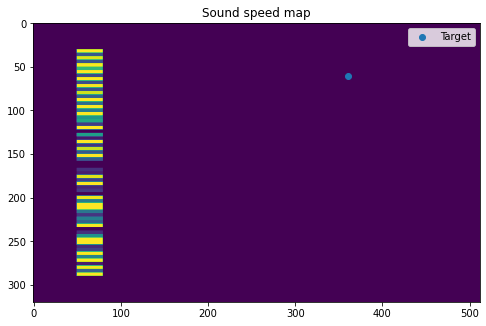

In [51]:
sos = get_sos(opt_sos_vector)
plt.figure(figsize=(8,8))
plt.imshow(sos.on_grid[...,0])
plt.title("Sound speed map")
plt.scatter(target[1], target[0], label="Target")
plt.legend()

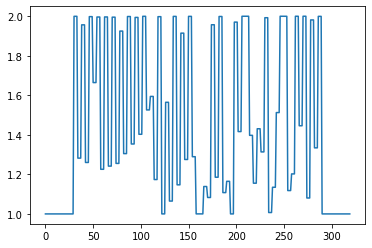

In [52]:
plt.plot(sos.on_grid[...,64,0])